In [1]:
## define the function to load the DLPFC dataset

import numpy as np
import scanpy as sc
import os
import pandas as pd

def load_DLPFC_data(id, path='./', dim_RNA=3000):

    adata = sc.read_h5ad(os.path.join(path, id, 'sampledata.h5ad'))
    adata.var_names_make_unique()
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=dim_RNA, check_values=False)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    Ann_df = pd.read_csv('%s/%s/annotation.txt'%(path, id), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
    adata = adata[adata.obs.notna().all(axis=1)].copy()
    sc.tl.rank_genes_groups(adata, "Ground Truth", method="wilcoxon")
    
    adata_ =  adata[:, adata.var['highly_variable']]
    adata = adata_.copy()
    adata.X = adata_.X.toarray()
    X = adata.X.copy()

    labels = list(adata.obs['Ground Truth'].values)
    labels_set = set(labels)
    labels_dict = {k:v for k, v in zip(labels_set, list(range(len(labels_set))))}
    gt = np.array([labels_dict[i] for i in labels])

    return X, gt, adata

In [2]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def hungarian_match(true_label, pred_label):
    l1 = list(set(true_label))
    numclass1 = len(l1)

    l2 = list(set(pred_label))
    numclass2 = len(l2)
    if numclass1 != numclass2:
        print('Class Not equal, Error!!!!')
        return 0

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(true_label) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if pred_label[i1] == c2]
            cost[i][j] = len(mps_d)
    
    row_ind, col_ind = linear_sum_assignment(-cost)
    
    new_predict = np.zeros(len(pred_label))
    for i, c in enumerate(l1):
        c2 = l2[col_ind[i]]
        ai = [ind for ind, elm in enumerate(pred_label) if elm == c2]
        new_predict[ai] = c
    
    return new_predict

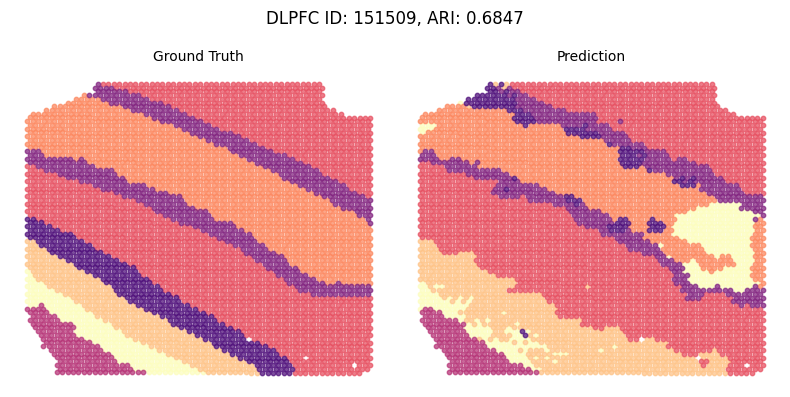

In [3]:
import numpy as np
import os
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import numpy as np
import matplotlib.pyplot as plt

cmap = 'magma'
c_list = plt.get_cmap(cmap)(np.linspace(0, 1, 9))[::-1]

path = './checkpoints/DLPFC'

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
id = '151509'

X, gt, adata = load_DLPFC_data(id, path='../DLPFC/', dim_RNA=3000)
loc = adata.obsm['spatial'] * np.array([1, -1])

pred = np.load(os.path.join(path, id, 'pred.npy'))

if len(set(pred)) == len(set(gt)):
    pred = hungarian_match(gt, pred)
for k, label in enumerate(set(gt)):
    ax[0].scatter(loc[gt==label, 0], loc[gt==label, 1], color=c_list[k], s=10, alpha=0.75, label=label)
for k, label in enumerate(set(pred)):
    ax[1].scatter(loc[pred==label, 0], loc[pred==label, 1], color=c_list[k], s=10, alpha=0.75)
    
for axis in ax:
    for sp in axis.spines.values():
        sp.set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])
ax[0].set_title('Ground Truth', fontsize=10)
ax[1].set_title('Prediction', fontsize=10)

fig.suptitle(f'DLPFC ID: {id}, ARI: {adjusted_rand_score(gt, pred):.4f}', fontsize=12)
plt.tight_layout()
plt.show()

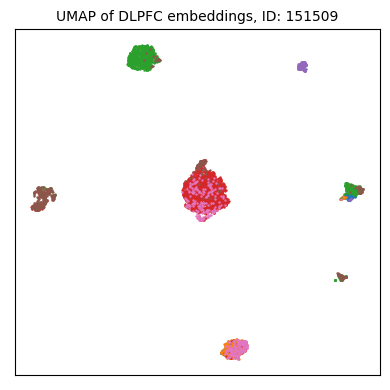

In [4]:
# Umap for DLPFC

import warnings
warnings.filterwarnings("ignore", message="The behavior of DataFrame.sum with axis=None is deprecated")

import torch
import os
import numpy as np
import umap
import matplotlib.pyplot as plt

c_list = plt.get_cmap('tab10').colors
path = './checkpoints/DLPFC'
id = '151509'

X, gt, adata = load_DLPFC_data(id, path='../DLPFC/', dim_RNA=3000)
emb = torch.load(os.path.join(path, id, 'emb.pth')).cpu().numpy()
emb_umap = umap.UMAP(n_components=2).fit_transform(emb)

plt.figure(figsize=(4, 4))
for i in range(len(np.unique(gt))):
    plt.scatter(emb_umap[gt==i, 0], emb_umap[gt==i, 1], color=c_list[i], s=0.5)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title(f'UMAP of DLPFC embeddings, ID: {id}', fontsize=10)
plt.tight_layout()
plt.show()

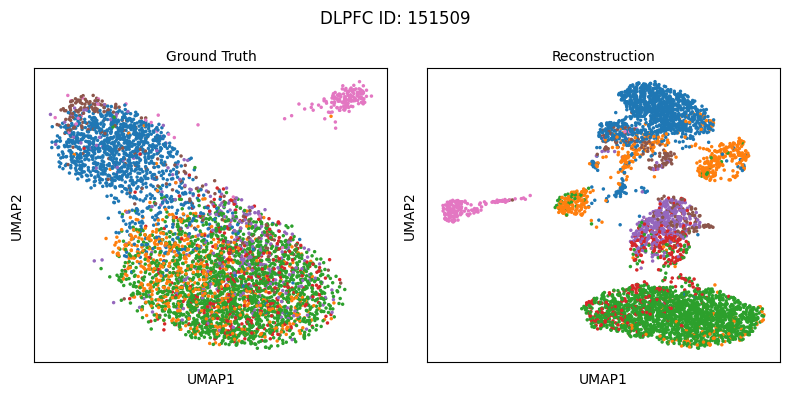

In [5]:
import matplotlib.pyplot as plt
import scanpy as sc

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

X, gt, adata = load_DLPFC_data(id, path='../DLPFC/', dim_RNA=3000)
adata.obs['gt'] = adata.obs['Ground Truth'].map(dict(zip(adata.obs['Ground Truth'].unique(), range(adata.obs['Ground Truth'].nunique()))))
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['gt'], ax=ax[0], show=False, cmap='viridis', legend_loc=None, title='')

path = './checkpoints/DLPFC'
id = '151509'
emb = torch.load(os.path.join(path, id, 'recon.pth')).cpu().numpy()
adata_recon = adata.copy()
adata_recon.X = emb
sc.pp.neighbors(adata_recon, use_rep='X')
sc.tl.umap(adata_recon)
sc.pl.umap(adata_recon, color=['gt'], ax=ax[1], show=False, layer='recon', title='', cmap='viridis', legend_loc=None)
ax[0].set_title('Ground Truth', fontsize=10)
ax[1].set_title('Reconstruction', fontsize=10)
fig.suptitle(f'DLPFC ID: {id}', fontsize=12)
plt.tight_layout()
plt.show()